## 7. 분류를 통한 데이터 분석 예제

본 노트북에서는 다양한 군집분석 기법 중 위계적 군집, K-평균 군집, DBSCAN을 이용한 분석 예제를 살펴봅니다.

### 7.1. 위계적 군집 분석 Hierarchical Clustering Analysis

In [1]:
# 준비작업
## 라이브러리 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Patch


from lesson3 import setup_korean_font
setup_korean_font()

np.random.seed(42)

본 노트북에서는 NCI의 암세포 데이터셋을 이용하여 군집분석을 진행합니다. 데이터셋의 구성에 대해서 별도로 학습해보시기 바랍니다.

In [2]:
## 데이터셋 및 라벨 로딩
### 사용자 정의함수를 만들 때에 가장 기본적으로 권장하는 함수 구성 방법입니다.
### try와 except 구문을 사용하여 기능을 구현하는 경우 그렇지 않은 경우와 어떤 차이가 있을지에 대해 한 번 고민해보시기 바랍니다.

def load_nci_data():
    """
    NCI 데이터셋을 다운로드하고 로드합니다.
    64개 암 세포주 x 6830개 유전자의 발현 데이터
    """
    url = 'https://hastie.su.domains/ElemStatLearn/datasets/nci.data.csv'
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # CSV 데이터 읽기
        csv_data = StringIO(response.text)
        df = pd.read_csv(csv_data, index_col=0)
        
        print(f"유전자 발현 데이터 크기: {df.shape}")
        
        return df
        
    except Exception as e:
        print(f"데이터 로드 오류: {e}")
        print("인터넷 연결을 확인해주세요.")
        return None

def load_nci_labels():
    """
    NCI 데이터셋의 암 타입 라벨을 다운로드하고 로드합니다.
    64개 암 세포주의 암 종류 정보
    """
    url = 'https://hastie.su.domains/ElemStatLearn/datasets/nci.label.txt'
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # 텍스트 데이터를 라인별로 읽기
        labels = response.text.strip().split('\n')
        
        print(f"암 타입 라벨 수: {len(labels)}")
        
        return labels
        
    except Exception as e:
        print(f"라벨 데이터 로드 오류: {e}")
        print("인터넷 연결을 확인해주세요.")
        return None

def clean_labels(labels):
    """
    원데이터 파일에서 라벨값에 공백이 있어서 이걸 그대로 가져오면 동일한 라벨을 다르게 인식하는 문제가 생깁니다.
    이 함수에서는 라벨값 앞뒤에 있는 공백을 제거합니다.
    """
    
    # 공백 제거 및 기본 정리
    cleaned_labels = []
    for label in labels:
        # 앞뒤 공백 제거
        cleaned = label.strip()
        cleaned_labels.append(cleaned)
   
    return cleaned_labels

# 데이터와 라벨 로딩
nci_data = load_nci_data()
nci_labels_raw = load_nci_labels()

유전자 발현 데이터 크기: (6830, 64)
암 타입 라벨 수: 64
암 타입 라벨 수: 64


In [3]:
# 데이터 전처리

## 라벨 데이터의 공백 제거
nci_labels = clean_labels(nci_labels_raw)

## 전치
nci_transposed = nci_data.T
print(f"전치 후 데이터 크기: {nci_transposed.shape} (샘플 × 유전자)")
    
## 표준화
scaler = StandardScaler()
nci_scaled = pd.DataFrame(
    scaler.fit_transform(nci_transposed),
    index=nci_transposed.index,
    columns=nci_transposed.columns
)
    
print(f"최종 분석 데이터 크기: {nci_scaled.shape}")
    
## 암 타입 라벨 정보 분석
cancer_type_counts = pd.Series(nci_labels).value_counts()
print(f"총 {len(set(nci_labels))}개의 고유 암 타입:")
print(cancer_type_counts)

## 색상 매핑 생성 (실제 암 타입용)
unique_real_types = list(set(nci_labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_real_types)))
real_cancer_type_colors = dict(zip(unique_real_types, colors))

전치 후 데이터 크기: (64, 6830) (샘플 × 유전자)
최종 분석 데이터 크기: (64, 6830)
총 14개의 고유 암 타입:
RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
K562B-repro    1
K562A-repro    1
MCF7A-repro    1
MCF7D-repro    1
Name: count, dtype: int64


HCA를 최단거리법, 최장거리법, 평균거리법을 이용하여 수행하고 그 결과를 비교해보겠습니다.  
덴드로그램을 통해 연결방법에 따라 군집화의 형태가 어떻게 달라지는지를 눈여겨보시기 바랍니다.

In [ ]:
# 분석
## 거리 행렬 계산
distance_matrix = pdist(nci_scaled, metric='euclidean')

print(f"거리 행렬 정보:")
print(f"• 크기: {distance_matrix.shape}")
print(f"• 최솟값: {distance_matrix.min():.3f}")
print(f"• 최댓값: {distance_matrix.max():.3f}")
print(f"• 평균: {distance_matrix.mean():.3f}")
print(f"• 표준편차: {distance_matrix.std():.3f}")

## 연결 방법 세 가지
linkage_methods = ['single', 'complete', 'average']
linkage_results = {}

## 군집분석 수행
for method in linkage_methods:
    Z = linkage(distance_matrix, method=method)
    linkage_results[method] = Z

거리 행렬 계산 중...
거리 행렬 정보:
• 크기: (2016,)
• 최솟값: 48.827
• 최댓값: 163.490
• 평균: 117.004
• 표준편차: 13.671


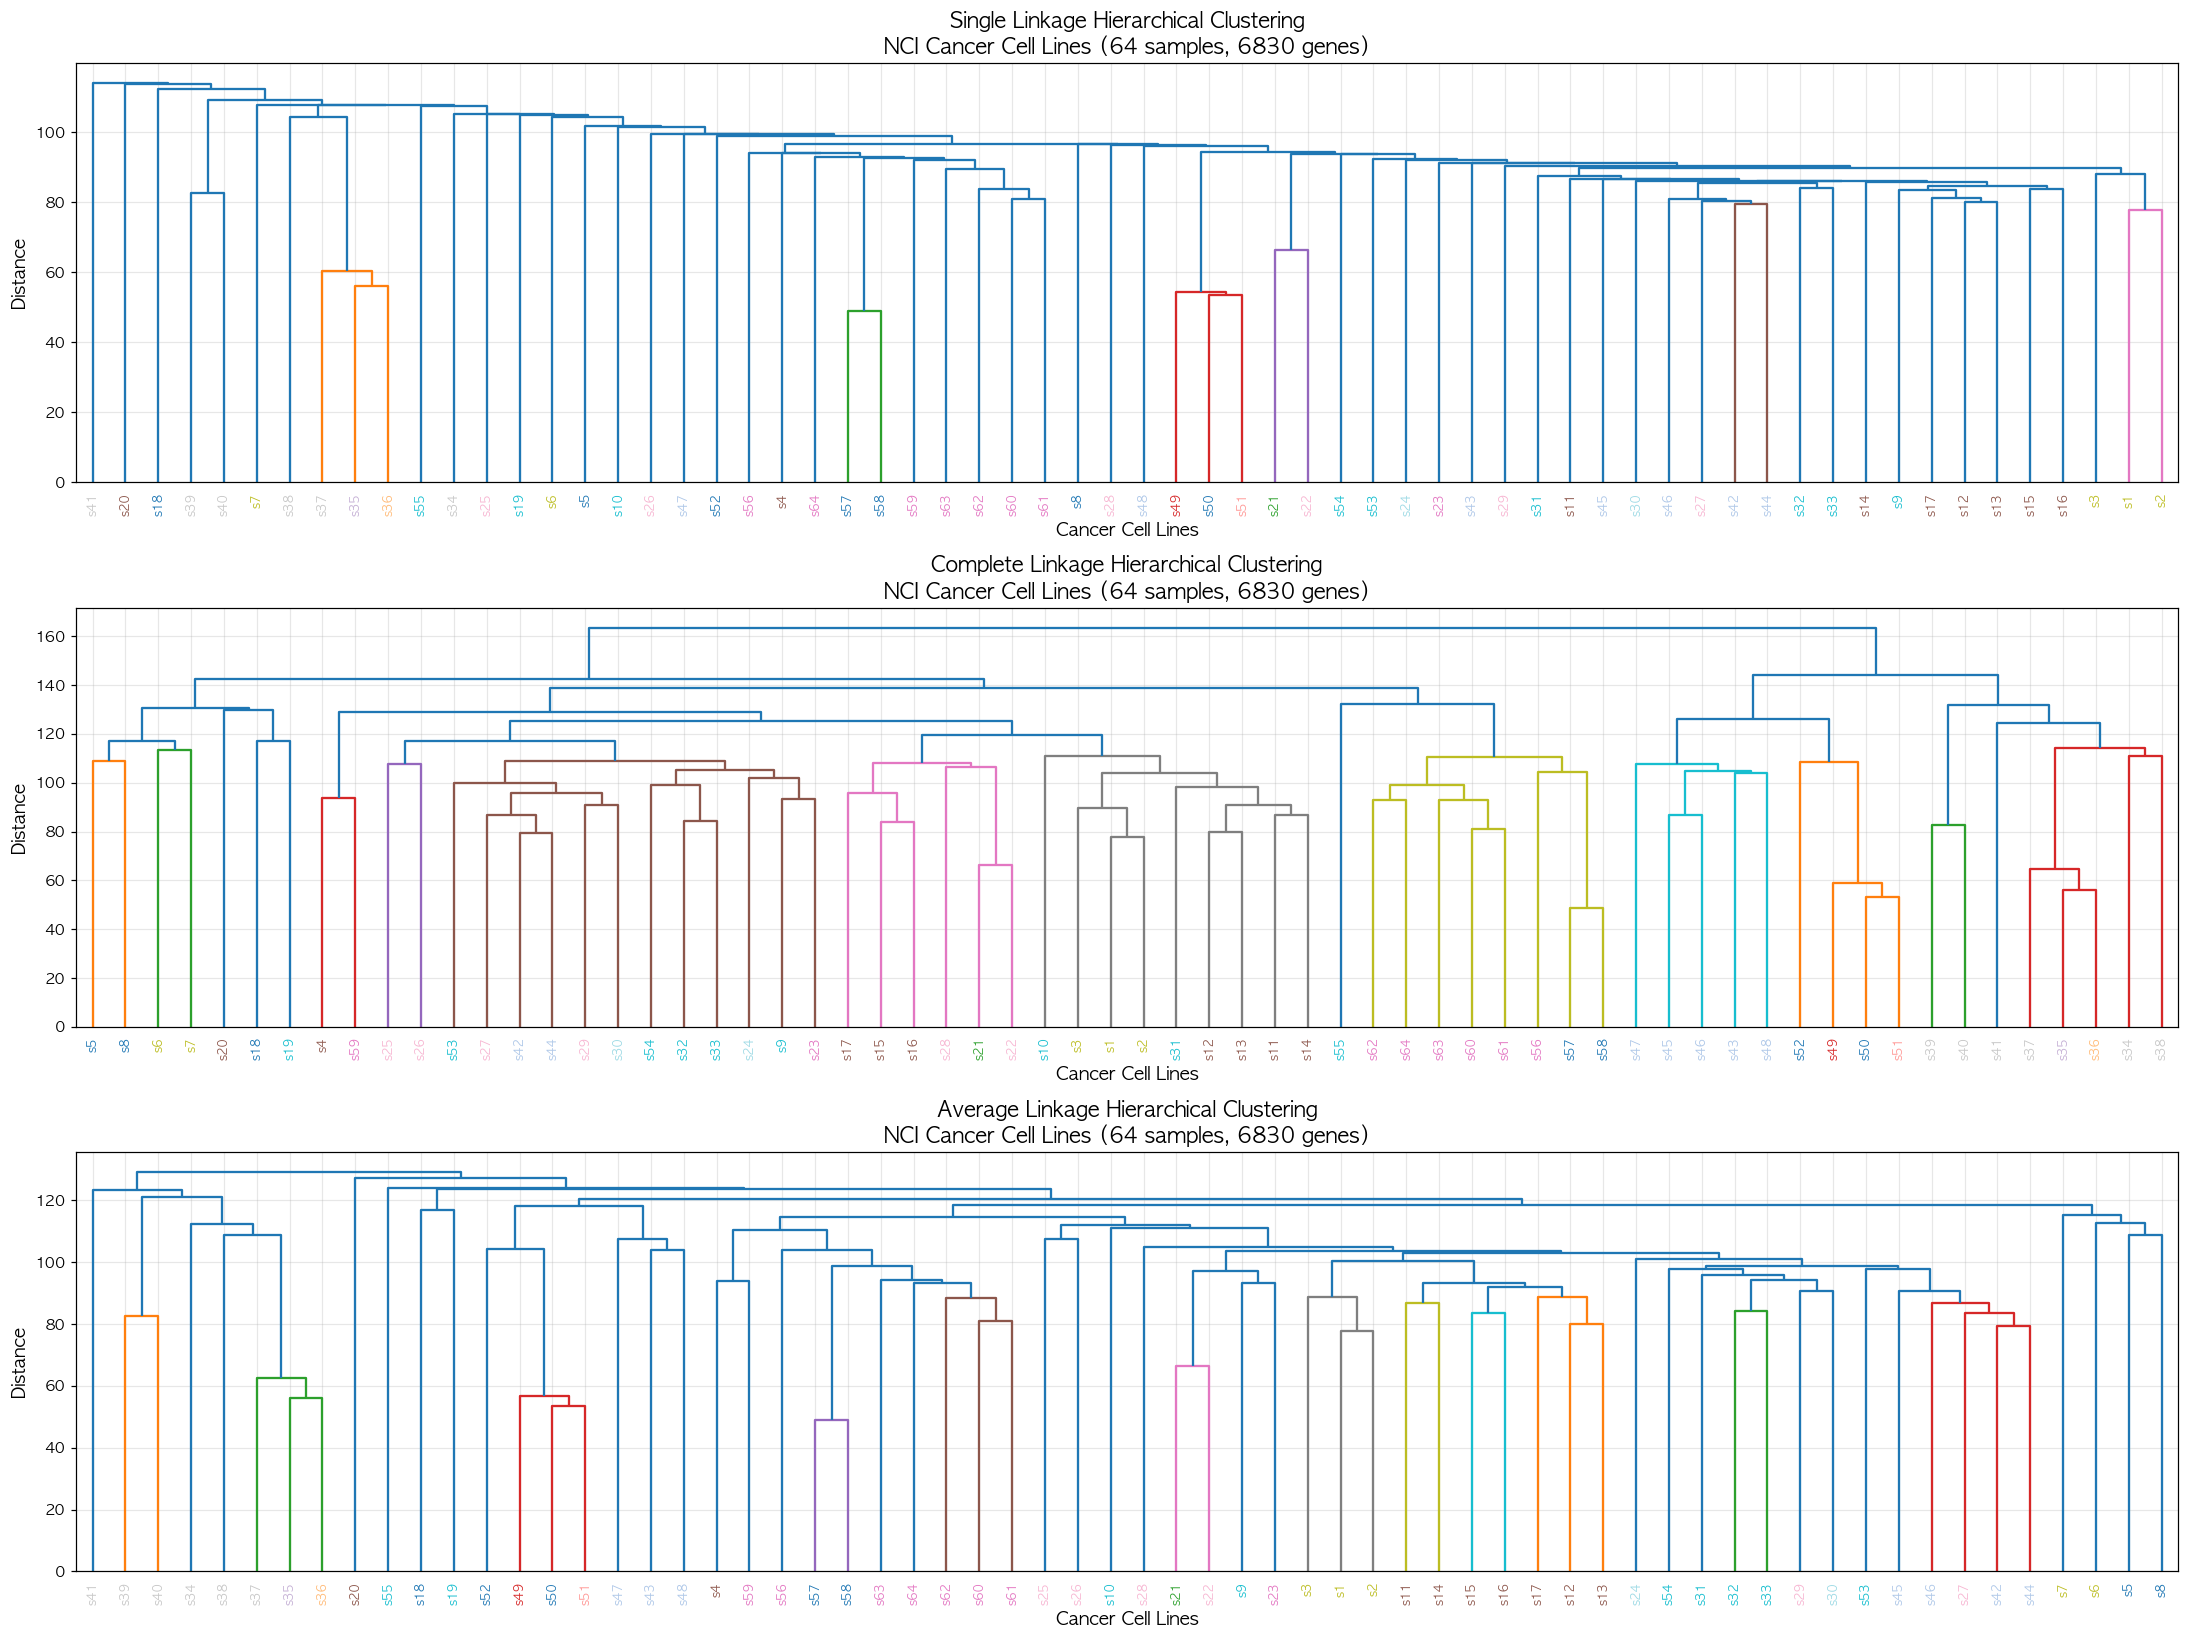

In [5]:
# 덴드로그램 시각화
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

sample_names = nci_scaled.index.tolist()

for idx, method in enumerate(linkage_methods):
    ax = axes[idx]
    
    # 덴드로그램 생성
    dendro = dendrogram(
        linkage_results[method],
        labels=sample_names,
        ax=ax,
        leaf_rotation=90,
        leaf_font_size=8,
        color_threshold=0.7*max(linkage_results[method][:,2])  # 색상 임계값 설정
    )
    
    ax.set_title(f'{method.capitalize()} Linkage Hierarchical Clustering\n'
                f'NCI Cancer Cell Lines (64 samples, 6830 genes)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Cancer Cell Lines', fontsize=12)
    ax.set_ylabel('Distance', fontsize=12)
    
    # x축 라벨 색상 설정 (실제 암 타입별)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        sample_name = lbl.get_text()
        sample_idx = sample_names.index(sample_name)
        cancer_type = nci_labels[sample_idx]
        lbl.set_color(real_cancer_type_colors[cancer_type])
    
    # 그리드 추가
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()    


군집화의 결과를 평가하는 지표로 **실루엣 지수**가 있습니다. 이를 활용해서 덴드로그램을 어느 높이에서 잘라 군집화를 할 것인지를 결정할 수 있습니다.  

눈여겨보실 부분은  

    (1) 실루엣 지수를 이용해서 위계적 군집의 분할을 결정할 수 있다.  
    (2) 이 경우 군집 분할이 이상적이지 않을 수 있다.  

는 점입니다.

In [6]:
# 필요한 패키지 로딩
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

# 각 연결방법에 대해 클러스터 수별 실루엣 점수 계산
silhouette_analysis = {}
optimal_clusters = {}

# 클러스터 수 범위 (2~15개)
cluster_range = range(2, 16)

for method in linkage_methods:
    silhouette_scores = []
    cluster_nums = []
    
    for n_clusters in cluster_range:
        # 덴드로그램에서 n_clusters개로 자르기
        clusters = fcluster(linkage_results[method], n_clusters, criterion='maxclust')
        
        actual_clusters = len(np.unique(clusters))
        
        if actual_clusters >= 2:  # 군집이 1개일 때에는 분리가 되지 않은 것이기 때문에 실루엣 점수가 나오지 않습니다.
            sil_score = silhouette_score(nci_scaled, clusters)
            silhouette_scores.append(sil_score)
            cluster_nums.append(n_clusters)
            
            print(f"  {n_clusters}개 클러스터: 실루엣 점수 = {sil_score:.4f}")
    
    # 결과 저장
    silhouette_analysis[method] = {
        'cluster_nums': cluster_nums,
        'silhouette_scores': silhouette_scores
    }
    
    # 최적 클러스터 수 찾기
    if silhouette_scores:
        best_idx = np.argmax(silhouette_scores)
        optimal_k = cluster_nums[best_idx]
        best_score = silhouette_scores[best_idx]
        optimal_clusters[method] = {
            'k': optimal_k,
            'score': best_score
        }
        print(f"최적 클러스터 수: {optimal_k}개 (실루엣 점수: {best_score:.4f})\n")

print(f"\n" + "=" * 70)
print("실루엣 지수 기준 최적 클러스터 수 요약")
print("=" * 70)

for method, result in optimal_clusters.items():
    print(f"{method.capitalize():>12} linkage: {result['k']:2d}개 클러스터 (점수: {result['score']:.4f})")

# 전체 최고 성능 방법 식별
# if optimal_clusters:
#     best_overall_method = max(optimal_clusters.keys(), 
#                              key=lambda x: optimal_clusters[x]['score'])
#     best_overall = optimal_clusters[best_overall_method]

  2개 클러스터: 실루엣 점수 = 0.0827
  3개 클러스터: 실루엣 점수 = 0.0658
  4개 클러스터: 실루엣 점수 = 0.0598
  5개 클러스터: 실루엣 점수 = 0.0741
  6개 클러스터: 실루엣 점수 = 0.0624
  7개 클러스터: 실루엣 점수 = 0.0790
  8개 클러스터: 실루엣 점수 = 0.0744
  9개 클러스터: 실루엣 점수 = 0.0613
  10개 클러스터: 실루엣 점수 = 0.0528
  11개 클러스터: 실루엣 점수 = 0.0468
  12개 클러스터: 실루엣 점수 = 0.0502
  13개 클러스터: 실루엣 점수 = 0.0497
  14개 클러스터: 실루엣 점수 = 0.0481
  15개 클러스터: 실루엣 점수 = 0.0432
최적 클러스터 수: 2개 (실루엣 점수: 0.0827)

  2개 클러스터: 실루엣 점수 = 0.0924
  3개 클러스터: 실루엣 점수 = 0.0813
  4개 클러스터: 실루엣 점수 = 0.0702
  5개 클러스터: 실루엣 점수 = 0.0754
  6개 클러스터: 실루엣 점수 = 0.0785
  7개 클러스터: 실루엣 점수 = 0.0868
  8개 클러스터: 실루엣 점수 = 0.0854
  9개 클러스터: 실루엣 점수 = 0.0861
  10개 클러스터: 실루엣 점수 = 0.0836
  11개 클러스터: 실루엣 점수 = 0.0961
  12개 클러스터: 실루엣 점수 = 0.0761
  13개 클러스터: 실루엣 점수 = 0.0797
  15개 클러스터: 실루엣 점수 = 0.0432
최적 클러스터 수: 2개 (실루엣 점수: 0.0827)

  2개 클러스터: 실루엣 점수 = 0.0924
  3개 클러스터: 실루엣 점수 = 0.0813
  4개 클러스터: 실루엣 점수 = 0.0702
  5개 클러스터: 실루엣 점수 = 0.0754
  6개 클러스터: 실루엣 점수 = 0.0785
  7개 클러스터: 실루엣 점수 = 0.0868
  8개 클러스터: 실루엣 점수 = 0.0854
  9개 클러

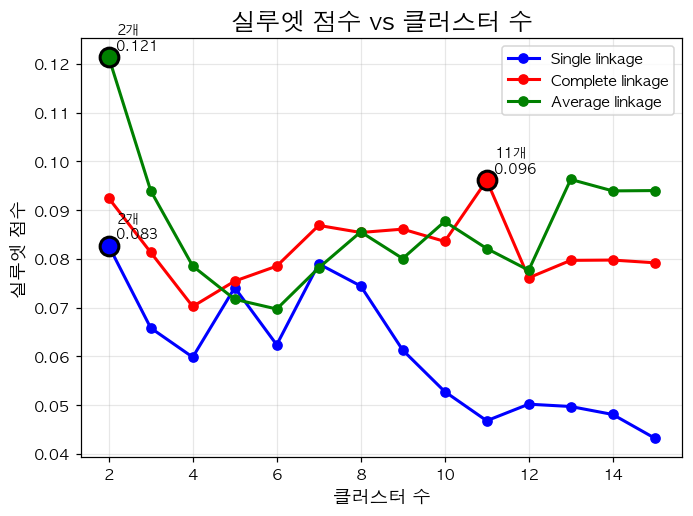

In [7]:
## 실루엣 지수를 이용한 덴드로그램 분할 결과 시각화

colors = ['blue', 'red', 'green']

for i, method in enumerate(linkage_methods):
    if method in silhouette_analysis:
        data = silhouette_analysis[method]
        plt.plot(data['cluster_nums'], data['silhouette_scores'], 
                'o-', color=colors[i], linewidth=2, markersize=6,
                label=f'{method.capitalize()} linkage')
        
        # 최적점 강조
        if method in optimal_clusters:
            opt_k = optimal_clusters[method]['k']
            opt_score = optimal_clusters[method]['score']
            plt.scatter([opt_k], [opt_score], color=colors[i], 
                       s=150, edgecolor='black', linewidth=2, zorder=5)
            plt.annotate(f'{opt_k}개\n{opt_score:.3f}', 
                        (opt_k, opt_score), 
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold')

plt.xlabel('클러스터 수', fontsize=12)
plt.ylabel('실루엣 점수', fontsize=12)
plt.title('실루엣 점수 vs 클러스터 수', fontweight='bold', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
## 실루엣 점수 기준 최적 클러스터링에서 실제 암 라벨 분포 분석

print("실루엣 점수 기준 최적 클러스터링에서 실제 암 라벨 분포 분석")
print("="*70)

cluster_cancer_distribution = {}

for method in linkage_methods:
    if method in optimal_clusters:
        opt_k = optimal_clusters[method]['k']
        opt_score = optimal_clusters[method]['score']
        
        # fcluster를 사용하여 최적 클러스터 수로 군집 나누기
        from scipy.cluster.hierarchy import fcluster
        cluster_labels = fcluster(linkage_results[method], opt_k, criterion='maxclust')
        
        print(f"\n{method.upper()} LINKAGE (최적 {opt_k}개 클러스터, 실루엣 점수: {opt_score:.4f})")
        print("-" * 60)
        
        # 클러스터별 암 타입 분포 분석
        cluster_distribution = {}
        for cluster_id in range(1, opt_k + 1):
            cluster_mask = cluster_labels == cluster_id
            cluster_samples = np.array(nci_labels)[cluster_mask]
            
            # 클러스터 내 암 타입 분포 계산
            cancer_counts = pd.Series(cluster_samples).value_counts()
            cluster_size = len(cluster_samples)
            
            cluster_distribution[cluster_id] = {
                'size': cluster_size,
                'cancer_counts': cancer_counts,
                'cancer_percentages': (cancer_counts / cluster_size * 100).round(1)
            }
            
            print(f"  클러스터 {cluster_id} ({cluster_size}개 샘플):")
            for cancer_type, count in cancer_counts.head(3).items():  # 각 군집별로 구성비율이 가장 높은 타입 3개 표시
                percentage = count / cluster_size * 100
                print(f"    • {cancer_type:<15}: {count:2d}개")
            
            if len(cancer_counts) > 3:
                others = cluster_size - cancer_counts.head(3).sum()
                print(f"    • 기타 {len(cancer_counts)-3}개 타입    : {others:2d}개")
        
        cluster_cancer_distribution[method] = cluster_distribution

실루엣 점수 기준 최적 클러스터링에서 실제 암 라벨 분포 분석

SINGLE LINKAGE (최적 2개 클러스터, 실루엣 점수: 0.0827)
------------------------------------------------------------
  클러스터 1 (63개 샘플):
    • RENAL          :  9개
    • NSCLC          :  9개
    • MELANOMA       :  8개
    • 기타 11개 타입    : 37개
  클러스터 2 (1개 샘플):
    • LEUKEMIA       :  1개

COMPLETE LINKAGE (최적 11개 클러스터, 실루엣 점수: 0.0961)
------------------------------------------------------------
  클러스터 1 (4개 샘플):
    • BREAST         :  2개
    • CNS            :  2개
  클러스터 2 (2개 샘플):
    • BREAST         :  1개
    • NSCLC          :  1개
  클러스터 3 (1개 샘플):
    • RENAL          :  1개
  클러스터 4 (2개 샘플):
    • RENAL          :  1개
    • MELANOMA       :  1개
  클러스터 5 (29개 샘플):
    • NSCLC          :  7개
    • RENAL          :  7개
    • OVARIAN        :  6개
    • 기타 5개 타입    :  9개
  클러스터 6 (8개 샘플):
    • MELANOMA       :  6개
    • BREAST         :  2개
  클러스터 7 (1개 샘플):
    • NSCLC          :  1개
  클러스터 8 (5개 샘플):
    • COLON          :  5개
  클러스터 9 (4개 샘플):
    • BREAST   

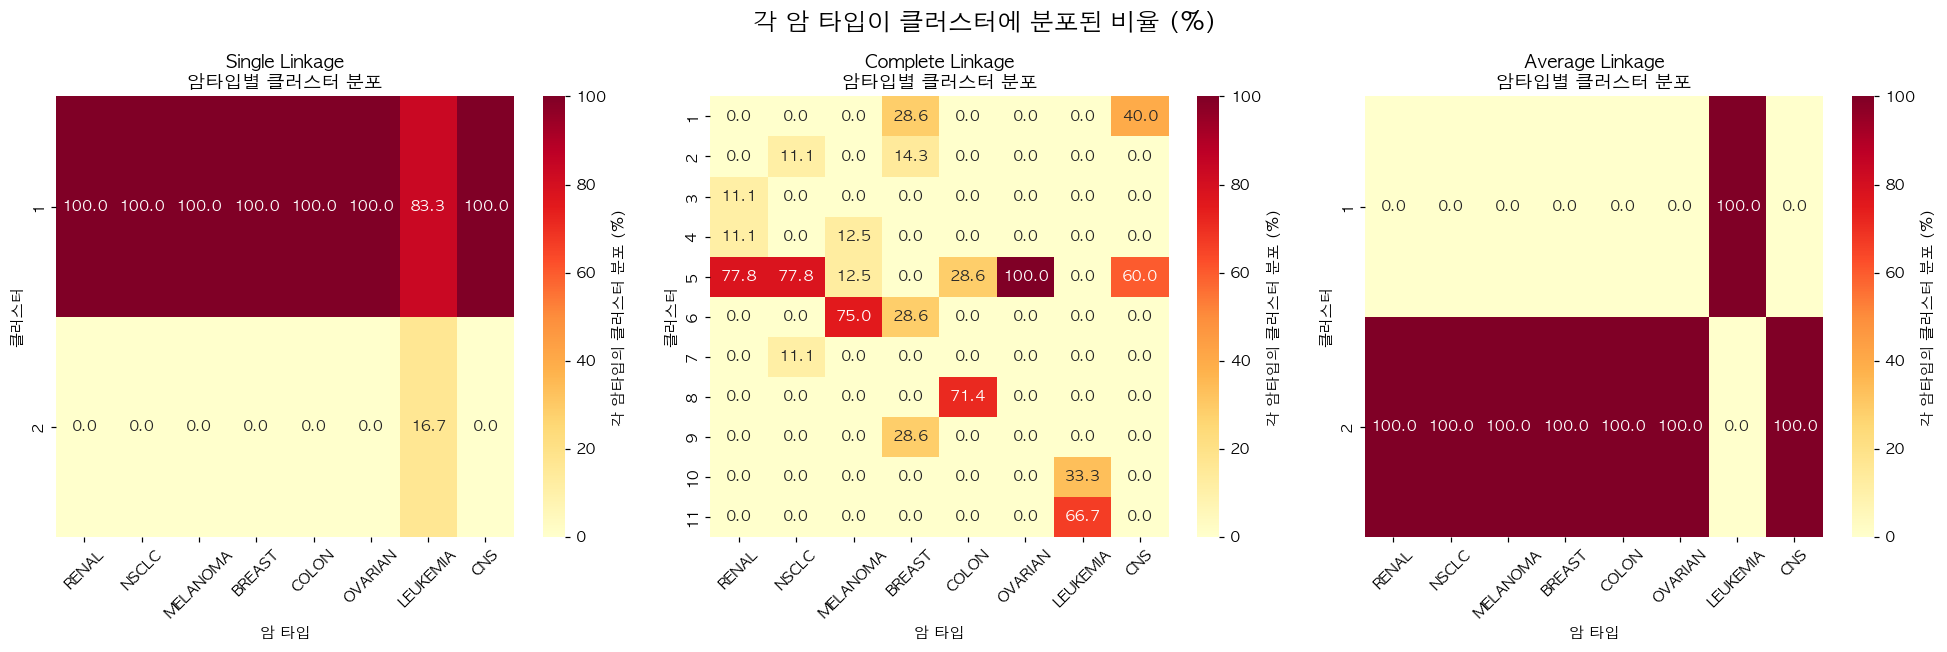

In [9]:
## 각 연결방법별 최적 군집과 암타입 분포 시각화 (암타입별 클러스터 분포)

import seaborn as sns

# 각 연결방법별로 클러스터-암타입 분포 히트맵 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, method in enumerate(linkage_methods):
    if method in optimal_clusters and method in cluster_cancer_distribution:
        opt_k = optimal_clusters[method]['k']
        distribution = cluster_cancer_distribution[method]
        
        cluster_labels = fcluster(linkage_results[method], opt_k, criterion='maxclust')
        
        df_temp = pd.DataFrame({
            'cluster': cluster_labels,
            'cancer_type': nci_labels
        })
        
        # 암타입별로 정규화: 각 암타입이 어떤 클러스터에 얼마나 분포되어 있는지
        crosstab = pd.crosstab(df_temp['cluster'], df_temp['cancer_type'], normalize='columns') * 100
        
        # 주요 암타입만 선택 (전체 샘플 수가 3개 이상인 것들)
        cancer_counts_total = pd.Series(nci_labels).value_counts()
        major_cancers = cancer_counts_total[cancer_counts_total >= 3].index[:10]  # 상위 10개만
        
        crosstab_filtered = crosstab[major_cancers]
        
        # 히트맵 그리기
        ax = axes[idx]
        sns.heatmap(crosstab_filtered, annot=True, fmt='.1f', cmap='YlOrRd', 
                   ax=ax, cbar_kws={'label': '각 암타입의 클러스터 분포 (%)'})
        
        ax.set_title(f'{method.capitalize()} Linkage\n암타입별 클러스터 분포', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('암 타입', fontsize=10)
        ax.set_ylabel('클러스터', fontsize=10)
        ax.tick_params(axis='x', rotation=45)

plt.suptitle('각 암 타입이 클러스터에 분포된 비율 (%)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
## 각 연결방법의 특성 확인
def analyze_linkage_characteristics(linkage_results):
    """
    각 연결방법별로 군집 간의 거리가 어떻게 분포하는지를 확인하는 함수입니다.
    """
    analysis = {}
    
    for method, Z in linkage_results.items():
        merge_distances = Z[:, 2]
        
        analysis[method] = {
            '최소_거리': merge_distances.min(),
            '평균_거리': merge_distances.mean(),
            '표준편차': merge_distances.std(),
            '최종_병합_거리': merge_distances[-1]  # 군집이 2개에서 1개로 줄어드는 단계에서 군집 사이의 거리
        }
    
    return analysis

linkage_analysis = analyze_linkage_characteristics(linkage_results)

# 결과 출력
print("=" * 80)
print("NCI 데이터 위계적 군집분석: 연결방법별 특성 비교")
print("=" * 80)

comparison_df = pd.DataFrame(linkage_analysis).T
print(comparison_df.round(3))

NCI 데이터 위계적 군집분석: 연결방법별 특성 비교
           최소_거리    평균_거리    표준편차  최종_병합_거리
single    48.827   89.848  14.222   113.933
complete  48.827  102.232  22.708   163.490
average   48.827   97.274  18.382   129.117


### 7.2. K-평균 군집분석

그리드 서치 방식으로 최적의 K값을 찾은 후 군집화를 하여 위계적 군집과 비교하는 코드입니다.  
  
최적의 K값을 찾기 위해 갭 통계량과 실루엣 지수 두 가지를 모두 이용한 후 결과를 비교합니다.  

In [17]:
# 갭 통계량은 시뮬레이션을 통해 값을 계산해야합니다. 
# 몇 개의 패키지가 있는데 가장 최근에 업데이트된 gapstatistics 패키지를 사용하겠습니다.
from gapstatistics.gapstatistics import GapStatistics

# K 값 범위 설정 (1부터 20까지)
k_range = range(1, 21)
sse_values = [] # SSE
silhouette_scores = [] # 실루엣 지수

# 각 K 값에 대해 K-means 수행 및 SSE 계산
for k in k_range:
    if k == 1:
        # K=1일 때는 SSE만 계산
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(nci_scaled)
        sse_values.append(kmeans.inertia_)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(nci_scaled)
        sil_score = silhouette_score(nci_scaled, cluster_labels)
        
        # SSE와 실루엣 지수 저장
        sse_values.append(kmeans.inertia_)
        silhouette_scores.append(sil_score)


# 최고 실루엣 점수 찾기
best_sil_idx = np.argmax(silhouette_scores)
best_k_sil = k_range_sil[best_sil_idx]
best_sil_score = silhouette_scores[best_sil_idx]


# 갭 통계량을 이용하여 최적 K 탐색

# GapStatistics 객체 생성
gap_stat = GapStatistics(
    algorithm=KMeans,
    distance_metric='euclidean',
    return_params=True
    )

max_k = 20 # k 값의 범위는 20까지

result = gap_stat.fit_predict(K=max_k, X=nci_scaled.values, n_iterations=20)
optimal_k_gap, gap_details = result

print(f"   최적 K: {optimal_k_gap}")


# 결과 출력
results_df = pd.DataFrame({
    'K': list(k_range),
    'SSE': sse_values,
    'Silhouette_Score': [0.0] + silhouette_scores if len(silhouette_scores) == len(k_range)-1 else [0.0] * len(k_range)
})

print(results_df)

   최적 K: 7
   갭 통계량 배열 길이: 20
   Wks 배열 길이: 20
     K            SSE  Silhouette_Score
0    1  437120.000000          0.000000
1    2  398638.638939          0.086136
2    3  373003.200551          0.075620
3    4  350737.487472          0.085167
4    5  336620.615731          0.081064
5    6  324517.481867          0.081959
6    7  318839.574486          0.073226
7    8  299919.208469          0.085268
8    9  290860.533622          0.077654
9   10  283742.866985          0.073724
10  11  273119.148969          0.088017
11  12  267650.267104          0.074663
12  13  260268.597169          0.075758
13  14  249855.976150          0.079217
14  15  244364.604383          0.081062
15  16  235697.907226          0.067405
16  17  229441.341130          0.078216
17  18  220821.943626          0.062411
18  19  211872.175463          0.087538
19  20  205537.535315          0.081862


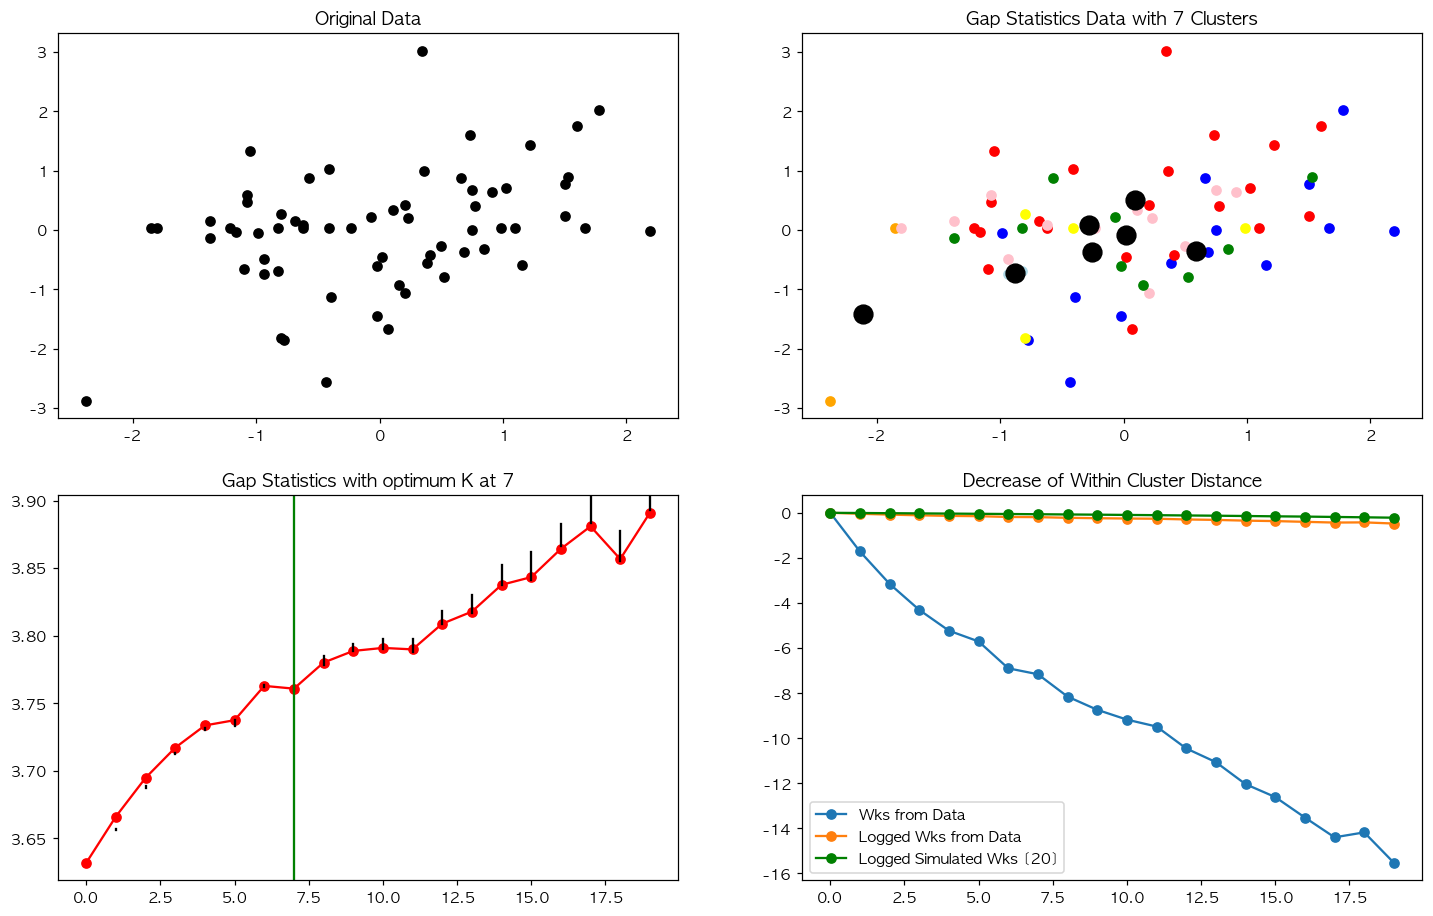

<Figure size 704x528 with 0 Axes>

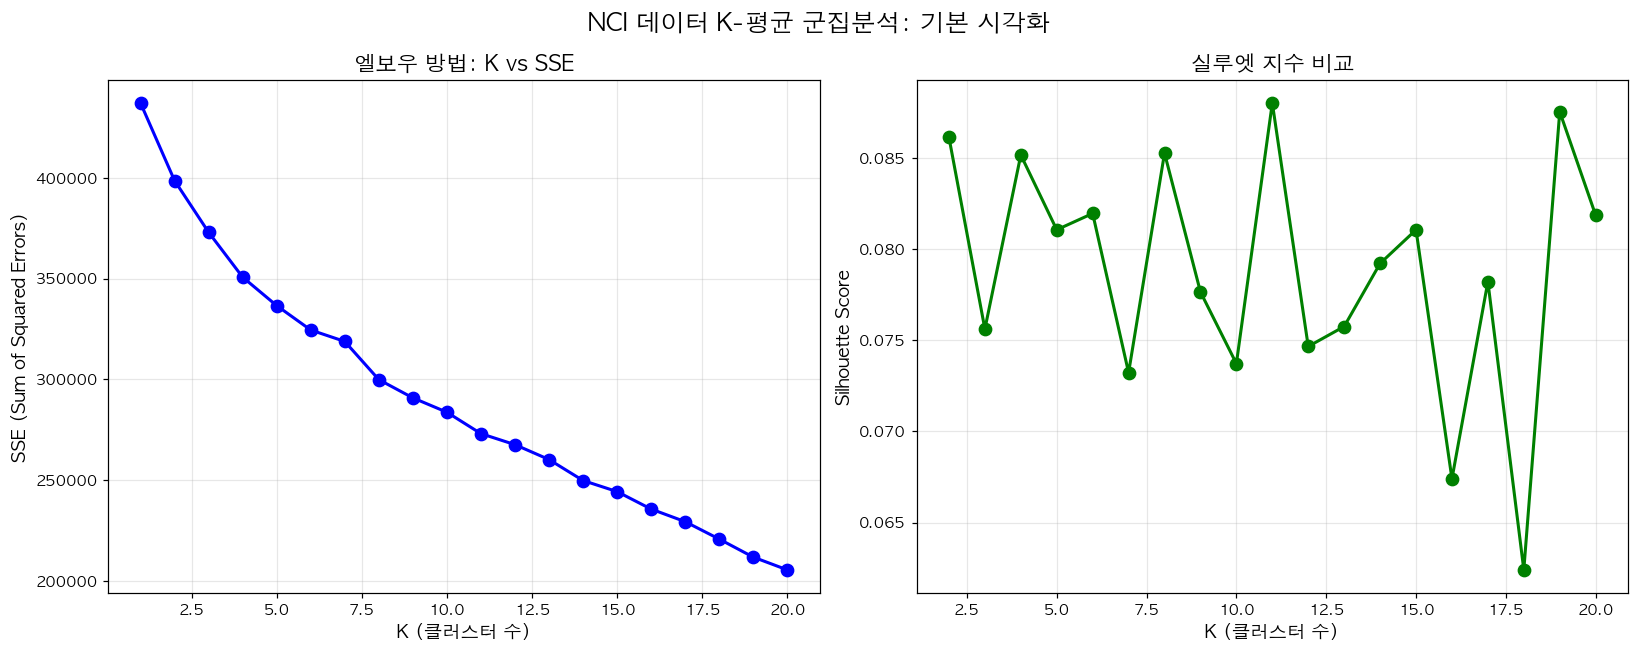

In [18]:
# 분석 결과 시각화
## gapstatistics 패키지에 내장된 메서드 사용
gap_stat.plot()
plt.tight_layout()
plt.show()
    
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# SSE vs K 그래프
ax1 = axes[0]
ax1.plot(k_range, sse_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('K (클러스터 수)', fontsize=12)
ax1.set_ylabel('SSE (Sum of Squared Errors)', fontsize=12)
ax1.set_title('엘보우 방법: K vs SSE', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3)

## 실루엣 지수 그래프
ax2 = axes[1]
if silhouette_scores:
    ax2.plot(k_range_sil, silhouette_scores, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('K (클러스터 수)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)  
    ax2.set_title('실루엣 지수 비교', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)

plt.suptitle('NCI 데이터 K-평균 군집분석: 기본 시각화', 
                fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [21]:
# 갭 통계량 기반 K-평균 (6개 클러스터)
gap_k = optimal_k_gap
kmeans_gap = KMeans(n_clusters=gap_k, random_state=42, n_init=10)
labels_gap = kmeans_gap.fit_predict(nci_scaled)

# 실루엣 지수 기반 K-평균 (11개 클러스터)
sil_k = best_k_sil
kmeans_sil = KMeans(n_clusters=sil_k, random_state=42, n_init=10)
labels_sil = kmeans_sil.fit_predict(nci_scaled)

# 위계적 군집 : Single Linkage (2개 클러스터)
single_k = optimal_clusters['single']['k']
labels_single = fcluster(linkage_results['single'], single_k, criterion='maxclust')

# 위계적 군집 : Complete Linkage (11개 클러스터)
complete_k = optimal_clusters['complete']['k']
labels_complete = fcluster(linkage_results['complete'], complete_k, criterion='maxclust')

# 위계적 군집 : Average Linkage (2개 클러스터)
average_k = optimal_clusters['average']['k']
labels_average = fcluster(linkage_results['average'], average_k, criterion='maxclust')

# 다섯 가지 방법의 결과를 하나의 데이터프레임으로 구성
clustering_comparison_df = pd.DataFrame({
    'Sample_ID': nci_scaled.index,
    'True_Cancer_Type': nci_labels,
    'Gap_KMeans': labels_gap,
    'Silhouette_KMeans': labels_sil,
    'Hierarchical_Single': labels_single,
    'Hierarchical_Complete': labels_complete,
    'Hierarchical_Average': labels_average
})

In [31]:
# 교차표 생성 함수
def create_crosstab_analysis(true_labels, predicted_labels):
    """
    교차표를 생성하고 분석하는 함수
    """
   
    # 교차표 생성 (행: 실제 암 타입, 열: 예측 클러스터)
    crosstab = pd.crosstab(
        pd.Series(true_labels, name='실제_암타입'), 
        pd.Series(predicted_labels, name='예측_클러스터'),
        margins=True
    )
    
    print("교차표 (행: 실제 암 타입, 열: 예측 클러스터):")
    print(crosstab)
    print("\n\n")

# 각 방법별 교차표 분석
print("갭 통계량 기반 K-평균 (6개 클러스터)")
crosstab_gap = create_crosstab_analysis(
    nci_labels, labels_gap
)

print("실루엣 지수 기반 K-평균 (11개 클러스터)")
crosstab_sil = create_crosstab_analysis(
    nci_labels, labels_sil
)

print("위계적 군집: Single Linkage (2개 클러스터)")
crosstab_single = create_crosstab_analysis(
    nci_labels, labels_single
)

print("위계적 군집: Complete Linkage (11개 클러스터)")
crosstab_complete = create_crosstab_analysis(
    nci_labels, labels_complete
)

print("위계적 군집: Average Linkage (2개 클러스터)")
crosstab_average = create_crosstab_analysis(
    nci_labels, labels_average
)

갭 통계량 기반 K-평균 (6개 클러스터)
교차표 (행: 실제 암 타입, 열: 예측 클러스터):
예측_클러스터      0   1   2  3  4  5  6  All
실제_암타입                                 
BREAST       2   2   0  1  2  0  0    7
CNS          0   1   1  3  0  0  0    5
COLON        0   0   1  0  0  6  0    7
K562A-repro  0   0   0  0  0  0  1    1
K562B-repro  0   0   0  0  0  0  1    1
LEUKEMIA     0   0   1  0  0  3  2    6
MCF7A-repro  1   0   0  0  0  0  0    1
MCF7D-repro  1   0   0  0  0  0  0    1
MELANOMA     0   0   1  0  7  0  0    8
NSCLC        0   1   7  1  0  0  0    9
OVARIAN      0   3   3  0  0  0  0    6
PROSTATE     0   1   1  0  0  0  0    2
RENAL        0   2   6  1  0  0  0    9
UNKNOWN      0   1   0  0  0  0  0    1
All          4  11  21  6  9  9  4   64



실루엣 지수 기반 K-평균 (11개 클러스터)
교차표 (행: 실제 암 타입, 열: 예측 클러스터):
예측_클러스터      0  1   2  3  4  5  6  7   8  9  10  All
실제_암타입                                              
BREAST       0  0   0  2  0  0  2  1   2  0   0    7
CNS          3  0   0  0  0  0  0  0   2  0   0 

## 7.3. DBSCAN

동일한 암세포 유전자 데이터로 DBSCAN을 수행하는 예제 코드입니다.  

하이퍼파라미터에 해당하는 eps와 min_samples_range의 변화에 따라 최종적으로 생성하는 군집이 어떻게 달라지는지를 확인해보겠습니다.

In [ ]:
# DBSCAN의 eps값 설정
## eps값을 설정하는 방법은 KNN을 이용하여 엘보우 포인트를 찾는 방법,
## 또는 데이터의 통계적 특성을 이용하는 방법 등이 있습니다.


## K-Distance Plot (KNN 기반)
from sklearn.neighbors import NearestNeighbors
k = 4  # 임의로 정한 초깃값입니다. 일반적으로 정해진 기준은 없고 3~5 사이의 값을 많이 사용합니다.
nbrs = NearestNeighbors(n_neighbors=k).fit(nci_scaled)
distances, indices = nbrs.kneighbors(nci_scaled)
k_distances = np.sort(distances[:, k-1], axis=0)[::-1]

## 엘보우 포인트 찾기 (기울기 변화가 가장 큰 지점)
diffs = np.diff(k_distances)
diff_ratios = np.abs(diffs[1:] / diffs[:-1])
elbow_idx = np.argmax(diff_ratios) + 1
suggested_eps_knn = k_distances[elbow_idx]

print(f"K={k}에서 엘보우 포인트 기반 eps: {suggested_eps_knn:.4f}")

## 전체 거리의 퍼센타일을 기반으로 설정
from scipy.spatial.distance import pdist

all_distances = pdist(nci_scaled, metric='euclidean')
eps_percentile_5 = np.percentile(all_distances, 5)
eps_percentile_10 = np.percentile(all_distances, 10)
eps_percentile_15 = np.percentile(all_distances, 15)

print(f"5th percentile: {eps_percentile_5:.4f}")
print(f"10th percentile: {eps_percentile_10:.4f}")
print(f"15th percentile: {eps_percentile_15:.4f}")

eps_methods = {
    'KNN (K-Distance)': suggested_eps_knn,
    '5th Percentile': eps_percentile_5,
    '10th Percentile': eps_percentile_10,
    '15th Percentile': eps_percentile_15
}

# 유효한 값들만 정렬해서 출력
# valid_eps = {k: v for k, v in eps_methods.items() if v is not None and not np.isnan(v)}
# sorted_eps = sorted(valid_eps.items(), key=lambda x: x[1])


# 기존 suggested_eps 업데이트 (KNN 기반 유지)
# suggested_eps = suggested_eps_knn

K=4에서 엘보우 포인트 기반 eps: 93.1967
5th percentile: 94.4185
10th percentile: 99.3335
15th percentile: 103.3027
 1. KNN (K-Distance)    : 93.1967
 2. 5th Percentile      : 94.4185
 3. 10th Percentile     : 99.3335
 4. 15th Percentile     : 103.3027


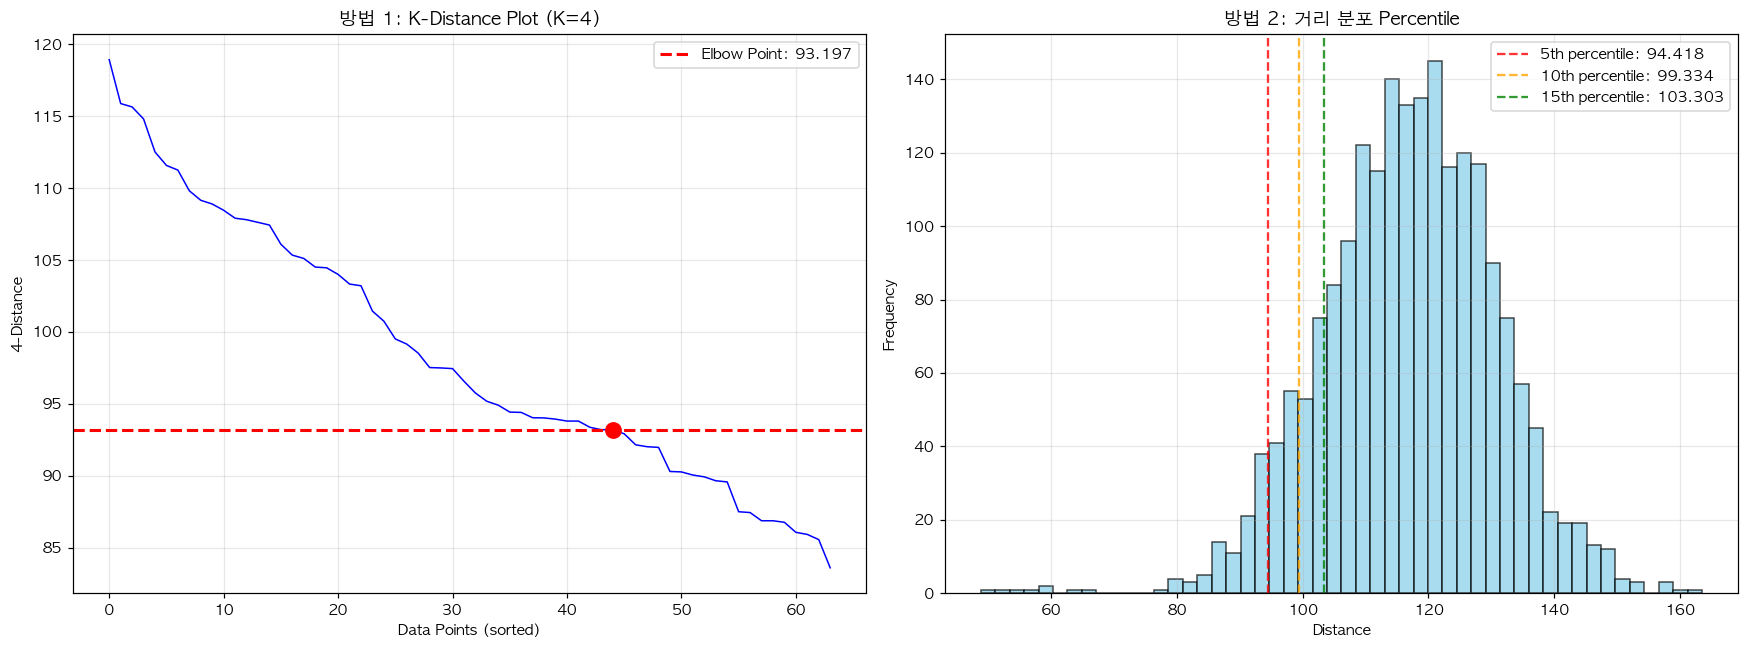

In [57]:
# 시각화

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

## K-Distance Plot
ax1 = axes[0]
ax1.plot(range(len(k_distances)), k_distances, 'b-', linewidth=1)
ax1.axhline(y=suggested_eps_knn, color='red', linestyle='--', linewidth=2, 
           label=f'Elbow Point: {suggested_eps_knn:.3f}')
ax1.scatter([elbow_idx], [k_distances[elbow_idx]], color='red', s=100, zorder=5)
ax1.set_title(f'방법 1: K-Distance Plot (K={k})', fontweight='bold')
ax1.set_xlabel('Data Points (sorted)')
ax1.set_ylabel(f'{k}-Distance')
ax1.legend()
ax1.grid(True, alpha=0.3)

## 거리 분포 히스토그램
ax2 = axes[1]
ax2.hist(all_distances, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(eps_percentile_5, color='red', linestyle='--', alpha=0.8, 
           label=f'5th percentile: {eps_percentile_5:.3f}')
ax2.axvline(eps_percentile_10, color='orange', linestyle='--', alpha=0.8,
           label=f'10th percentile: {eps_percentile_10:.3f}')
ax2.axvline(eps_percentile_15, color='green', linestyle='--', alpha=0.8,
           label=f'15th percentile: {eps_percentile_15:.3f}')
ax2.set_title('방법 2: 거리 분포 Percentile', fontweight='bold')
ax2.set_xlabel('Distance')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## eps 값에 따라 명칭 지정
recommended_eps_values = {
    'conservative': eps_percentile_5, # 세밀한 클러스터 탐색
    'balanced': eps_percentile_10,
    'liberal': eps_percentile_15, # 큰 클러스터 탐색
    'knn_based': suggested_eps_knn # KNN 기반 기준
}

In [59]:
# DBSCAN 라이브러리 로딩
from sklearn.cluster import DBSCAN

## 앞서 설정한 eps값 설정
eps_knn = suggested_eps_knn
eps_percentile = eps_percentile_10

## min_samples을 2~5 범위에서 그리드 설정
parameter_combinations = [
    {'eps': eps_knn, 'min_samples': 2, 'description': 'KNN eps, min_samples=2'},
    {'eps': eps_knn, 'min_samples': 3, 'description': 'KNN eps, min_samples=3'},
    {'eps': eps_knn, 'min_samples': 4, 'description': 'KNN eps, min_samples=4'},
    {'eps': eps_knn, 'min_samples': 5, 'description': 'KNN eps, min_samples=5'},
    
    {'eps': eps_percentile, 'min_samples': 2, 'description': '10th Percentile eps, min_samples=2'},
    {'eps': eps_percentile, 'min_samples': 3, 'description': '10th Percentile eps, min_samples=3'},
    {'eps': eps_percentile, 'min_samples': 4, 'description': '10th Percentile eps, min_samples=4'},
    {'eps': eps_percentile, 'min_samples': 5, 'description': '10th Percentile eps, min_samples=5'}
]

dbscan_results = []

for i, params in enumerate(parameter_combinations, 1):
    eps = params['eps']
    min_samples = params['min_samples']
    description = params['description']
    
    # DBSCAN 실행
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(nci_scaled)
    
    # 결과값
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    noise_ratio = n_noise / len(nci_scaled)
    
    # 결과 저장
    dbscan_results.append({
        'combination': i,
        'description': description,
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': noise_ratio,
        'labels': cluster_labels
    })

# 결과 요약표
print(f"\n📊 **파라미터 조합별 결과 요약**:")
print("-" * 80)
summary_df = pd.DataFrame([
    {
        '조합': f"{r['combination']}번",
        'eps': f"{r['eps']:.3f}",
        'min_samples': r['min_samples'],
        '클러스터수': r['n_clusters'],
        '노이즈비율': f"{r['noise_ratio']:.1%}",
    }
    for r in dbscan_results
])
print(summary_df.to_string(index=False))


📊 **파라미터 조합별 결과 요약**:
--------------------------------------------------------------------------------
조합    eps  min_samples  클러스터수 노이즈비율
1번 93.197            2      6 32.8%
2번 93.197            3      4 39.1%
3번 93.197            4      2 48.4%
4번 93.197            5      2 51.6%
5번 99.334            2      3 21.9%
6번 99.334            3      2 25.0%
7번 99.334            4      1 29.7%
8번 99.334            5      1 29.7%


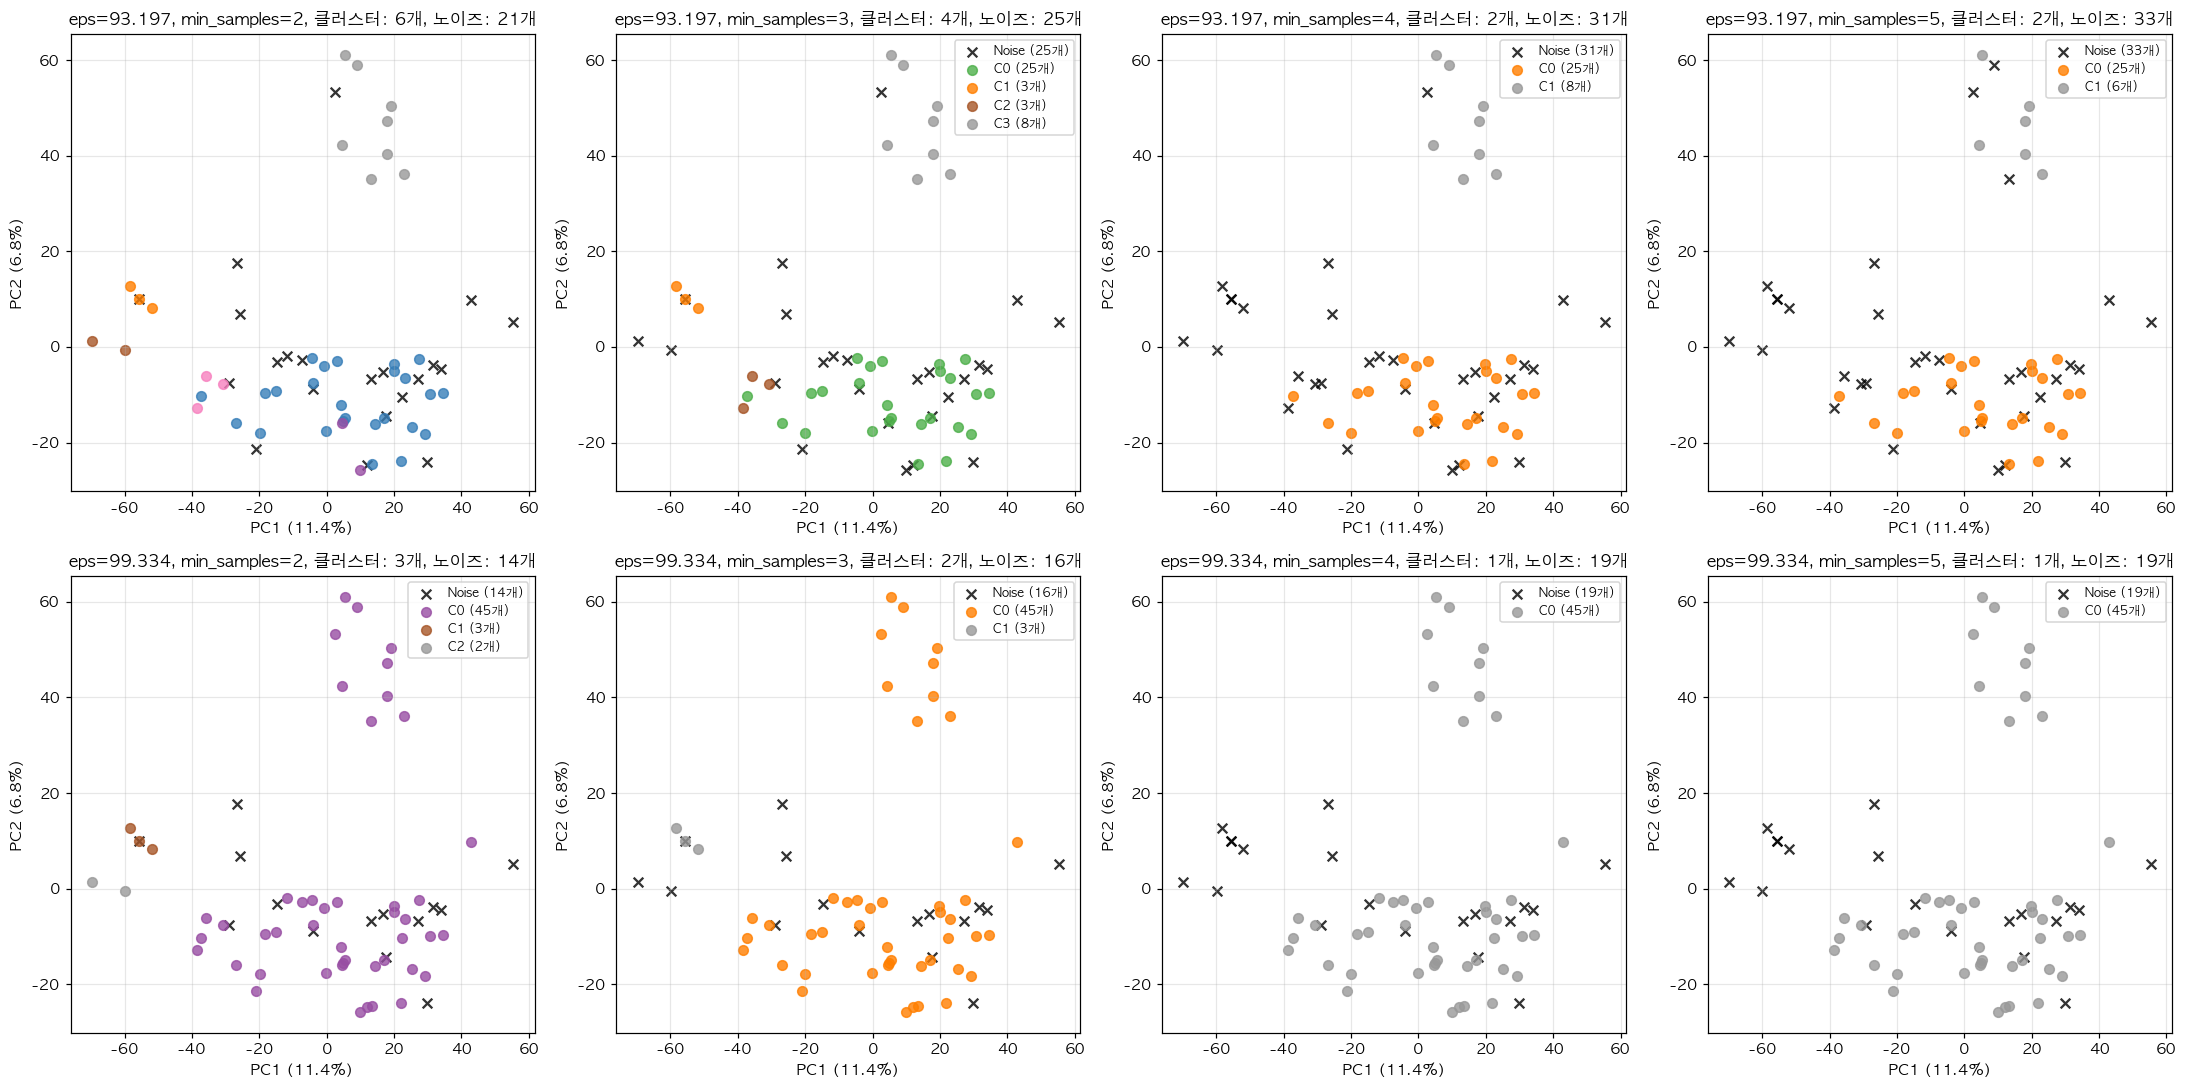

In [64]:
# DBSCAN 결과 시각화

# PCA를 이용하여 2차원에서 시각화
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
nci_2d = pca.fit_transform(nci_scaled)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, result in enumerate(dbscan_results):
    ax = axes[idx]
    labels = result['labels']
    eps = result['eps']
    min_samples = result['min_samples']
    n_clusters = result['n_clusters']
    n_noise = result['n_noise']
    description = result['description']
    
    # 고유 라벨 확인
    unique_labels = set(labels)
    n_colors = max(len(unique_labels), 1)
    colors = plt.cm.Set1(np.linspace(0, 1, n_colors))
    
    # 클러스터별로 점 그리기
    for k, col in zip(sorted(unique_labels), colors):
        if k == -1:
            class_member_mask = (labels == k)
            xy = nci_2d[class_member_mask]
            if len(xy) > 0:
                ax.scatter(xy[:, 0], xy[:, 1], c='black', marker='x', 
                          s=40, alpha=0.8, label=f'Noise ({len(xy)}개)')
        else:
            class_member_mask = (labels == k)
            xy = nci_2d[class_member_mask]
            if len(xy) > 0:
                ax.scatter(xy[:, 0], xy[:, 1], c=[col], s=40, alpha=0.8, 
                          label=f'C{k} ({len(xy)}개)')
    
    # 제목과 라벨 설정
    ax.set_title(f'eps={eps:.3f}, min_samples={min_samples}, '
                f'클러스터: {n_clusters}개, 노이즈: {n_noise}개', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 범례 (클러스터가 많지 않을 때만)
    if len(unique_labels) <= 6:
        ax.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

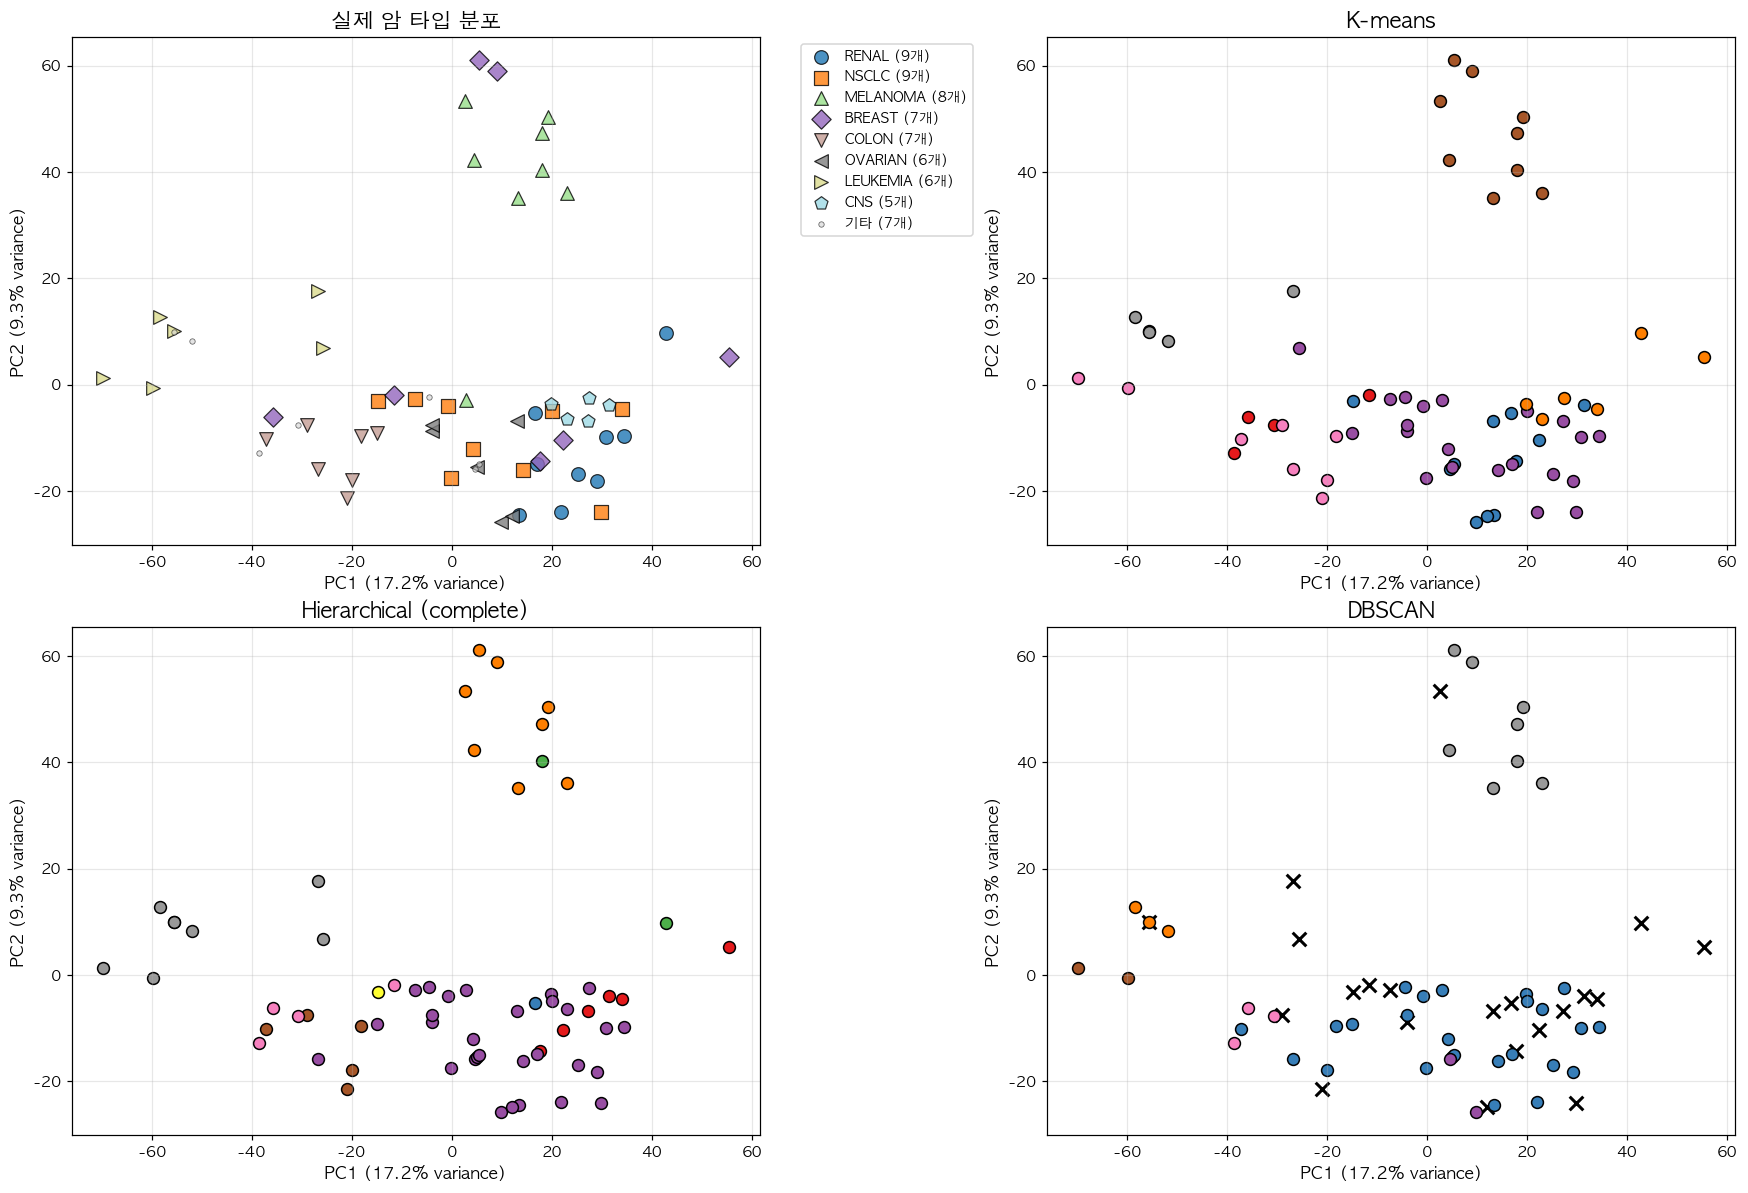

In [ ]:
# 실제 암 타입 분포와 군집화 결과 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

## 비교할 주요 군집화 방법들
methods_to_compare = ['K-means', 'Hierarchical (complete)', 'DBSCAN']

## 주요 암 타입들 식별 (샘플 수가 많은 상위 타입들)
cancer_type_counts = pd.Series(nci_labels).value_counts()
major_cancer_types = cancer_type_counts.head(8).index.tolist()
ax = axes[0]
colors_cancer = plt.cm.tab20(np.linspace(0, 1, len(major_cancer_types)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

for i, cancer_type in enumerate(major_cancer_types):
    mask = np.array(nci_labels) == cancer_type
    if np.any(mask):
        ax.scatter(nci_2d[mask, 0], nci_2d[mask, 1], 
                    c=[colors_cancer[i]], alpha=0.8, s=80,
                    marker=markers[i % len(markers)],
                    label=f'{cancer_type} ({np.sum(mask)}개)',
                    edgecolors='black', linewidth=0.8)

## 기타 암 타입
other_mask = ~np.isin(nci_labels, major_cancer_types)
if np.any(other_mask):
    ax.scatter(nci_2d[other_mask, 0], nci_2d[other_mask, 1], 
                c='lightgray', alpha=0.6, s=50, marker='.',
                label=f'기타 ({np.sum(other_mask)}개)',
                edgecolors='black', linewidth=0.5)

ax.set_title('실제 암 타입 분포', fontweight='bold', fontsize=14)
ax.set_xlabel('PC1 (17.2% variance)', fontsize=11)
ax.set_ylabel('PC2 (9.3% variance)', fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

## 나머지: 각 군집화 방법별 결과
method_labels_dict = {
    'K-means': labels_gap, # 갭 통계량 기반 K-means
    'Hierarchical (complete)': labels_complete, # Complete linkage
    'DBSCAN': dbscan_results[0]['labels'] # DBSCAN (eps=0.932, min_samples=2)
}

for idx, method_name in enumerate(methods_to_compare):
    if method_name in method_labels_dict:
        ax = axes[idx + 1]
        labels = method_labels_dict[method_name]
        
        unique_clusters = np.unique(labels)
        cluster_colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
        
        for j, cluster_val in enumerate(unique_clusters):
            mask = labels == cluster_val
            if method_name == 'DBSCAN' and cluster_val == -1:
                ax.scatter(nci_2d[mask, 0], nci_2d[mask, 1], 
                            c='black', marker='x', s=80, alpha=1,
                            label=f'노이즈 ({np.sum(mask)}개)', linewidth=2)
            else:
                ax.scatter(nci_2d[mask, 0], nci_2d[mask, 1], 
                            c=[cluster_colors[j]], alpha=1, s=60,
                            label=f'클러스터 {cluster_val} ({np.sum(mask)}개)',
                            edgecolors='black', linewidth=1)
        
        ax.set_title(f'{method_name}', 
                    fontweight='bold', fontsize=14)
        ax.set_xlabel('PC1 (17.2% variance)', fontsize=11)
        ax.set_ylabel('PC2 (9.3% variance)', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        if len(unique_clusters) <= 6:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

생각해볼 문제  

(1) 군집분석의 결과가 실제 데이터의 특성을 어느 정도까지 분리시킬 수 있었는가?  

(2) 각 기법에서 초모수의 변화에 따라 군집분석의 결과가 어떻게 달라지는가?  

(3) 각각의 군집분석 기법의 군집화 결과를 비교했을 때에 무엇을 기준으로 군집화의 결과를 평가하는 것이 좋을까?  

(4) 군집분석을 진행하는 과정, 결과를 확인하는 과정에서 군집분석 이외에 어떤 분석기법이나 데이터 분석과 관련된 지식을 동원했는가?